##Предварительная обработка

In [287]:
import pandas as pd
import numpy as np

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [318]:
with open("Банк_3мес_данные.csv", encoding="Windows-1251") as data:
    df = pd.read_csv(data, sep=";")
df = df.rename(columns={"Кредит (актив)":"asset",  #переименовываем для удобства
                        "Вклад (пассив)":"liability",
                        "Дата погашения":"mat_date",
                        "Срок погашения, дней":"days_mat",
                        "Ставка, %":"rate",
                        "[ОТВЕТ] Номер группы":"answ",
                        "Пример группировки (для первых 20 сделок)":"group"
                        })
df = df.drop("Unnamed: 7", axis=1)
df

,asset,liability,mat_date,days_mat,rate,answ,group
0,0.0,33000000.0,04.06.2018,74,2.0246,NaN,1.0
1,100000000.0,0.0,11.06.2018,81,2.0714,NaN,1.0
2,550000000.0,0.0,07.05.2018,46,1.7935,NaN,2.0
3,0.0,5000000.0,11.06.2018,81,2.0714,NaN,1.0
4,0.0,5000000.0,11.06.2018,81,2.0714,NaN,1.0
...,...,...,...,...,...,...,...
2170,3500000.0,0.0,13.06.2018,83,2.0888,NaN,NaN
2171,0.0,46500000.0,13.06.2018,83,2.0888,NaN,NaN
2172,29300000.0,0.0,13.06.2018,83,2.0888,NaN,NaN
2173,0.0,121500000.0,13.06.2018,83,2.0888,NaN,NaN


In [319]:
df_ex = df.sort_values("group").drop("answ", axis=1).head(20) #кусочек датафрейма для проверки

##Разбираемся с формулой

In [320]:
def calculate_rwa_for_groups(data, group="group"): #принимает датафрейм

    total_assets, total_liabs = 0, 0

    for g in data[group].unique():
            gross, net = 0.1, 0.4
            if g == -1: #этот будут несгруппированные активы
                total_assets += sum(data[data[group] == g]["asset"])
                total_liabs += sum(data[data[group] == g]["liability"])
            else:
                residue = sum(data[data[group] == g]["asset"]) - sum(data[data[group] == g]["liability"])

                if residue >= 0:
                    total_assets += residue
                if residue < 0:
                    total_liabs += abs(residue)

    rwa = (total_assets + total_liabs)*gross + abs(total_assets - total_liabs)*net

    #RWA = ((∑ Актив + ∑ Пассив)* 𝑤_𝑔𝑟𝑜𝑠𝑠 + |∑ Актив − ∑ Пассив| * 𝑤_𝑛𝑒𝑡
    #получается нужно минимизировать total assets и total liabilities
    #RWA=383300000 correct result for df_ex

    return rwa


In [321]:
calculate_rwa_for_groups(df_ex) #проверяем что функция корректна

383300000.0

Посмотрим возможные RWA

1) если бы все активы и пассивы неттировались(то есть были бы объединены в одну группу неттирования)

2) без неттирования

3) неттирование только одинаковых по дате и ставке строк

 это даст представление о минимальном и максимальном возможных числах

In [322]:
df["zero_group"] = 0
print("RWA, если бы все активы и пассивы неттировались:", calculate_rwa_for_groups(df, group="zero_group"))
df = df.drop("zero_group",axis=1)

RWA, если бы все активы и пассивы неттировались: 1016236493.5900003


In [323]:
df["zero_group"] = -1
print("RWA, если бы все активы и пассивы не неттировались:", calculate_rwa_for_groups(df, group="zero_group"))
df = df.drop("zero_group",axis=1)

RWA, если бы все активы и пассивы не неттировались: 8678152412.522001


In [301]:
def group_by_rate_and_days(data):
    data['new'] = data.groupby(['rate', 'days_mat']).ngroup()
    return data

print("RWA, если бы неттировались только активы и пассивы с одинаковой ставкой и сроком:", calculate_rwa_for_groups(df2, group="new"))

RWA, если бы неттировались только активы и пассивы с одинаковой ставкой и сроком: 2012448514.8140004


На всякий случай создадим функцию проверки, чтобы потом смотреть, соответствуют ли условиям полученные группы неттирования

In [302]:
def netting_checker(data, group="group"):

  for g in data[group].unique():
      flag = ''
      net_group = data[data[group] == g]
      num = (data[group] == g).sum()
      days_range = net_group["days_mat"].max() - net_group["days_mat"].min()
      rate_range = round(net_group["rate"].max() - net_group["rate"].min(), 4)
      total_group = data[data[group] == g]["asset"].sum() - data[data[group] == g]["asset"].sum()

      if days_range > 30 or rate_range > 0.15:
        flag = 'there is a problem'

      if g == -1:
        print(f"group {int(g)}: {num}, days_range={days_range}, rate_range={rate_range}", "not groupped")
      else:
        print(f"group {int(g)}: {num}, days_range={days_range}, rate_range={rate_range}", flag)

In [303]:
netting_checker(df_ex)

group 1: 7, days_range=10, rate_range=0.0823 
group 2: 10, days_range=20, rate_range=0.1246 
group 3: 1, days_range=0, rate_range=0.0 
group 4: 1, days_range=0, rate_range=0.0 
group 5: 1, days_range=0, rate_range=0.0 


##Посмотрим на графики

In [23]:
def scatter_of_groups(data, groupped = True, group="group"):
       plt.style.use('_mpl-gallery')

       if groupped:
              plt.figure(figsize=(5, 5))
              for g in data[group].unique():
                     x = data[data[group] == g]["days_mat"].to_numpy()
                     y = data[data[group] == g]["rate"].to_numpy()

                     cmap = cm.get_cmap('gist_rainbow')
                     color = cmap(np.random.rand())

                     plt.scatter(x, y, label= g, color = color)

              plt.show()
       else:
              x = data["days_mat"].to_numpy()
              y = data["rate"].to_numpy()

              cmap = cm.get_cmap('gist_rainbow')
              color = cmap(np.random.rand())

              plt.figure(figsize=(5, 5))
              plt.scatter(x, y, color = color)

              plt.show()

<ipython-input-23-eecdaf1f7457>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_rainbow')


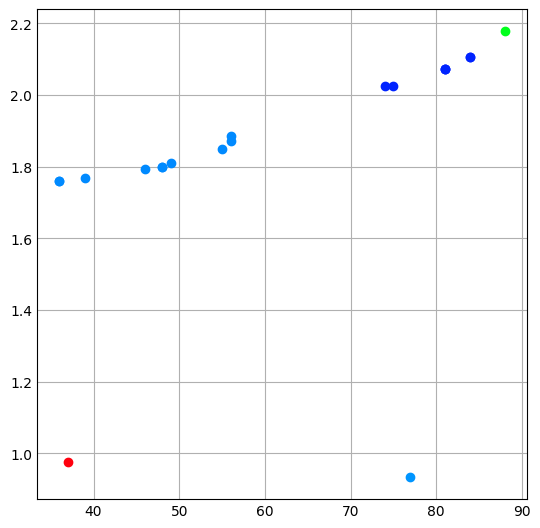

In [24]:
scatter_of_groups(df_ex)

<ipython-input-23-eecdaf1f7457>:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_rainbow')


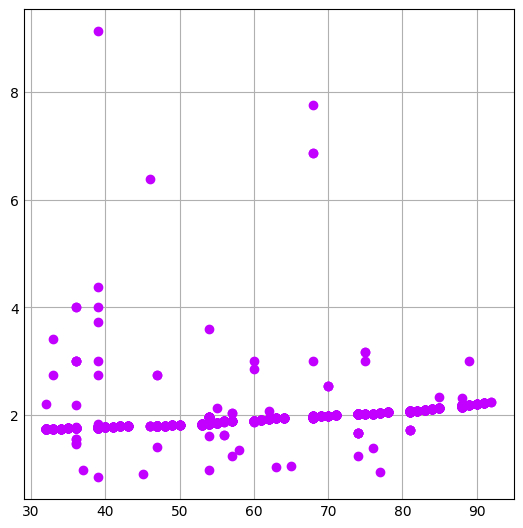

In [25]:
scatter_of_groups(df, groupped=False)

Наибольшую сложность для разбиения на группы представляет "линия"

Сначала можно отсеить по расстоянию активы и пассивы, которые точно не группируются с другими(расстояние до ближайшего соседа больше 0.15 по y и больше 30 по x)
но кажется это будет очень не эффективно, особенно если их много(квадратичная сложность обеспечена)

##Алгоритм

1.   Сортируем датафрейм по ставке
2.   Всем активам и пассивам до группировки присваиваем значение -1
2.   Запускаем цикл, который идет по строкам последовательно, проверяя по условию разницы в днях и ставке, можно ли объединить группу со предыдущей
  *   Если цикл находит две последовательно идущие строки, которые могут быть объединены, им присваивается номре группы
  *  У строк, которые не получилось ни с чем объединить, остается группа -1



3. При переходе на новую строку:

  *   в случае, если объединение возможно, присваиваем строке ту же группу, что и у предыдущей
  *   в случае, если объединение невозможно, присваиваем строке следующий номер группы, таким образом начиная новую группу с нее

4. К полученной группировке строк применяем функцию подсчета RWA по группам


In [324]:
def calculate_min_rwa(data, group="group", sort="rate"):
    data = data.sort_values(sort).reset_index()
    n = len(data)
    data[group] = -1
    group_id = 0
    i = 0

    while i < n:
        #начинаем с инициализации группы в строке под номером i
        start = i
        end = i
        min_rate = max_rate = data.at[i, 'rate']
        min_day = max_day = data.at[i, 'days_mat']

        #добавляем в текущую группу следующую строку, пока она соответствует условию
        for j in range(i + 1, n):
            new_rate = data.at[j, 'rate']
            new_day = data.at[j, 'days_mat']

            rate_diff = new_rate - min_rate
            try_min_day = min(min_day, new_day)
            try_max_day = max(max_day, new_day)

            if ((try_max_day - try_min_day) > 30) or (rate_diff > 0.15):
                break #прерываем цикл -> заканчиваем пополнение группы

            end = j
            max_rate = new_rate
            min_day = try_min_day
            max_day = try_max_day

            '''
            когда закончили пополнение группы,
            меняем в столбце с группой в строках с индексами от start до end
            значения на номер группы
            '''
        if end > start:
            data.loc[start:end, group] = group_id
            group_id += 1
            i = end + 1
        else:
            i += 1

    return calculate_rwa_for_groups(data, group=group), data

###Проверяем корректность работы алгоритма на тестовых данных:

In [274]:
calculate_min_rwa(df_ex, group="label")[0]

383300000.0

In [275]:
netting_checker(calculate_min_rwa(df_ex, group="label")[1], group="label")

group -1: 3, days_range=51, rate_range=1.2435 not groupped
group 0: 10, days_range=20, rate_range=0.1246 
group 1: 7, days_range=10, rate_range=0.0823 


In [276]:
df_ex_new = calculate_min_rwa(df_ex, group="label")[1]

In [278]:
#сделаем разные названия всем аквтивам и пассивам, не попавшим в группы неттирования, как в примере
def diff_ungroupped(data, group="group"):
  maxn = data[group].max()

  new_group = maxn + 1

  data.loc[data[group] == -1, group] = range(new_group, new_group + len(data[data[group] == -1]))

  return data

*   RWA корректный
*   Разбиение на группы соответствует условиям



In [279]:
diff_ungroupped(df_ex_new, group="label")

,index,asset,liability,mat_date,days_mat,rate,group,label
0,9,50000000.0,0.0,07.06.2018,77,0.9340,5.0,2
1,8,0.0,50000000.0,28.04.2018,37,0.9745,4.0,3
2,13,111000000.0,0.0,27.04.2018,36,1.7603,2.0,0
3,12,121700000.0,0.0,27.04.2018,36,1.7603,2.0,0
4,14,0.0,55600000.0,30.04.2018,39,1.7669,2.0,0
5,2,550000000.0,0.0,07.05.2018,46,1.7935,2.0,0
6,11,0.0,24500000.0,09.05.2018,48,1.7999,2.0,0
7,15,0.0,22000000.0,09.05.2018,48,1.7999,2.0,0
8,16,0.0,10000000.0,10.05.2018,49,1.8105,2.0,0
9,17,11100000.0,0.0,16.05.2018,55,1.8500,2.0,0


### Применяем к основным данным

In [325]:
calculate_min_rwa(df, group="answ")[0]

1302189239.803999

In [ ]:
netting_checker(calculate_min_rwa(df, group="answ")[1], group="answ")

In [328]:
df_res = diff_ungroupped(calculate_min_rwa(df, group="answ")[1], group="answ")
df_res.sort_values("index").reset_index(drop=True).drop("index", axis=1) #приводим все в исходный вид

,asset,liability,mat_date,days_mat,rate,answ,group
0,0.0,33000000.0,04.06.2018,74,2.0246,7,1.0
1,100000000.0,0.0,11.06.2018,81,2.0714,8,1.0
2,550000000.0,0.0,07.05.2018,46,1.7935,6,2.0
3,0.0,5000000.0,11.06.2018,81,2.0714,8,1.0
4,0.0,5000000.0,11.06.2018,81,2.0714,8,1.0
...,...,...,...,...,...,...,...
2170,3500000.0,0.0,13.06.2018,83,2.0888,8,NaN
2171,0.0,46500000.0,13.06.2018,83,2.0888,8,NaN
2172,29300000.0,0.0,13.06.2018,83,2.0888,8,NaN
2173,0.0,121500000.0,13.06.2018,83,2.0888,8,NaN


<ipython-input-23-eecdaf1f7457>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_rainbow')


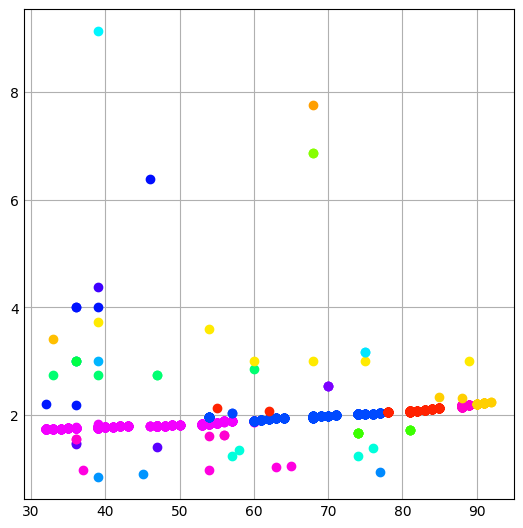

In [135]:
scatter_of_groups(df_res, group="answ")

##Сохраняем ответ

In [329]:
#возвращаем имена переменных и сохраняем в csv файл
df_final = df_res.rename(columns={"asset": "Кредит (актив)",
                        "liability": "Вклад (пассив)",
                        "mat_date": "Дата погашения",
                        "days_mat": "Срок погашения, дней",
                        "rate": "Ставка, %",
                        "answ": "[ОТВЕТ] Номер группы",
                        "group": "Пример группировки (для первых 20 сделок)"
                        })
df_final.to_csv("Банк_3мес_данные_ответ.csv", sep=";")